In [23]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler

# Import PyTorch modules
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

pd.set_option('display.max_columns', None)

In [24]:
# Get all csv files starting with 'g_15' in data directory
data_dir = '../data'
csv_files = [f for f in os.listdir(data_dir) if f.startswith('g_30') and f.endswith('.csv')]

# Read and combine all matching CSV files
dfs = []
for file in csv_files:
    df = pd.read_csv(os.path.join(data_dir, file))
    df['game_date'] = pd.to_datetime(df['game_date'])  # Convert date for sorting
    dfs.append(df)

# Concatenate all dataframes and sort by game_date
processed_df = pd.concat(dfs, ignore_index=True)
processed_df = processed_df.sort_values('game_date').reset_index(drop=True)

In [25]:
# list(processed_df.columns)
processed_df['toi'].value_counts().sort_values(ascending=False)

toi
47.674    9
48.124    8
48.069    7
48.215    7
48.419    7
         ..
49.555    1
51.647    1
49.244    1
47.517    1
46.570    1
Name: count, Length: 4021, dtype: int64

In [26]:
# Drop rows where time on ice (toi) is less than 30:00
# First, convert toi to minutes if it's in MM:SS format
if processed_df['res_toi'].dtype == 'object':
    # Convert MM:SS format to minutes as float
    def convert_toi_to_minutes(toi):
        if pd.isna(toi):
            return np.nan
        parts = toi.split(':')
        if len(parts) == 2:
            return float(parts[0]) + float(parts[1])/60
        return float(toi)
    
    processed_df['toi_minutes'] = processed_df['res_toi'].apply(convert_toi_to_minutes)
else:
    # If toi is already numeric, assume it's in minutes
    processed_df['toi_minutes'] = processed_df['res_toi']

# Filter out rows with less than 30 minutes of ice time
processed_df = processed_df[processed_df['toi_minutes'] >= 20].reset_index(drop=True)

# Display the shape of the dataframe after filtering
print(f"DataFrame shape after filtering out games with TOI < 30:00: {processed_df.shape}")


DataFrame shape after filtering out games with TOI < 30:00: (7406, 235)


In [ ]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import time

# Start timing
start_time = time.time()

# Define features (using the comprehensive set that performed well)
features = [
    'home', 'b2b', 'opp_b2b',
    'g_gsaa_rolling_avg', 'g_shots_against_rolling_avg', 'g_shots_against_rolling_std',
    'g_sv_pct_rolling_avg', 'g_sv_pct_rolling_std',
    'g_hdsv_pct_rolling_avg', 'g_mdsv_pct_rolling_avg',
    'g_games_last_7', 'g_days_rest',
    'ff%', 'cf%', 'sf%', 'xgf%', 'hdcf%', 'scf%'
]

# Prepare the data
X = processed_df[features].copy()
y = processed_df['res_saves']

# Handle missing values
X = X.fillna(X.mean())

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

# Initialize the model
rf = RandomForestRegressor(random_state=42)

# Set up TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Initialize GridSearchCV with TimeSeriesSplit
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=tscv,
    scoring='neg_mean_squared_error',
    n_jobs=-1,  # Use all available cores
    verbose=2
)

# Fit the grid search
print("Starting grid search...")
grid_search.fit(X_scaled, y)

# Print results
print("\nBest parameters found:")
print(grid_search.best_params_)

print("\nBest score:")
print(f"RMSE: {np.sqrt(-grid_search.best_score_):.4f}")

# Get detailed CV results
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results = cv_results.sort_values('rank_test_score')

print("\nTop 5 parameter combinations:")
top_5_params = cv_results[['params', 'mean_test_score', 'std_test_score']].head()
top_5_params['rmse'] = np.sqrt(-top_5_params['mean_test_score'])
print(top_5_params)

# Calculate execution time
execution_time = time.time() - start_time
print(f"\nTotal execution time: {execution_time:.2f} seconds")

# Train final model with best parameters
best_model = RandomForestRegressor(**grid_search.best_params_, random_state=42)
best_model.fit(X_scaled, y)

# Get feature importance from best model
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': best_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nFeature importance from best model:")
print(feature_importance)

# Plot feature importance
plt.figure(figsize=(12, 6))
sns.barplot(data=feature_importance, x='importance', y='feature')
plt.title('Feature Importance from Best Model')
plt.tight_layout()
plt.show()


Total number of parameter combinations: 16
Total number of fits: 48

Starting grid search...
Fitting 3 folds for each of 16 candidates, totalling 48 fits

Best parameters found:
{'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 1.0, 'subsample': 0.8}

Best score:
RMSE: 6.7502

Final Model Metrics:
R² Score: 0.138
MAE: 5.000
RMSE: 6.310


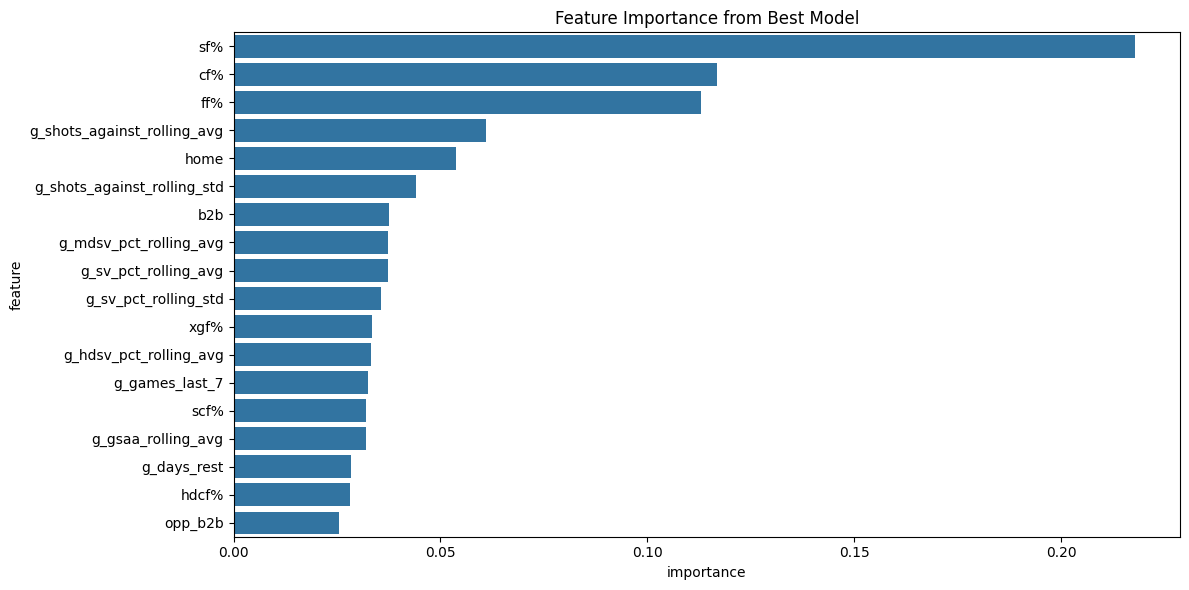

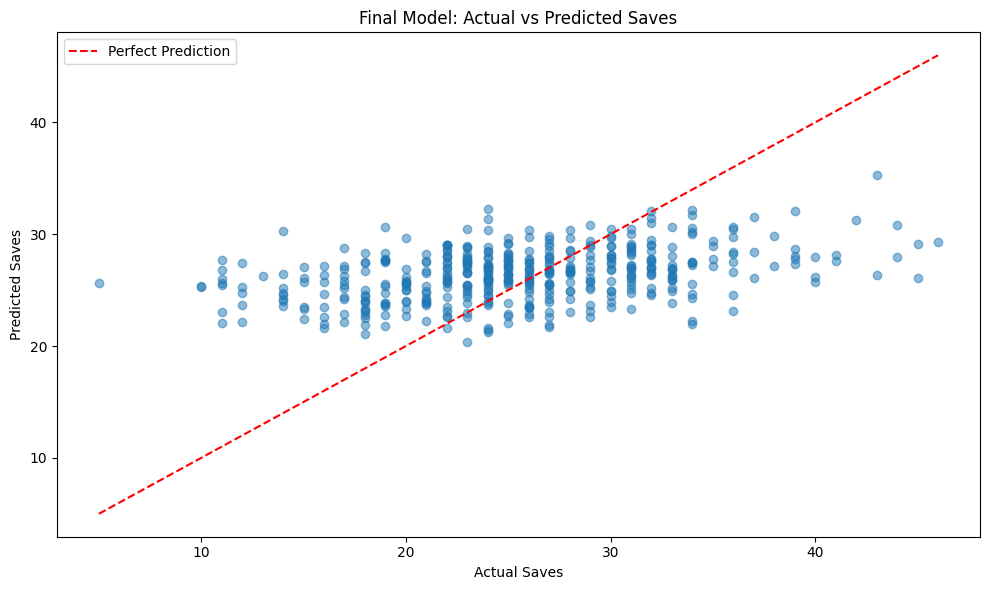

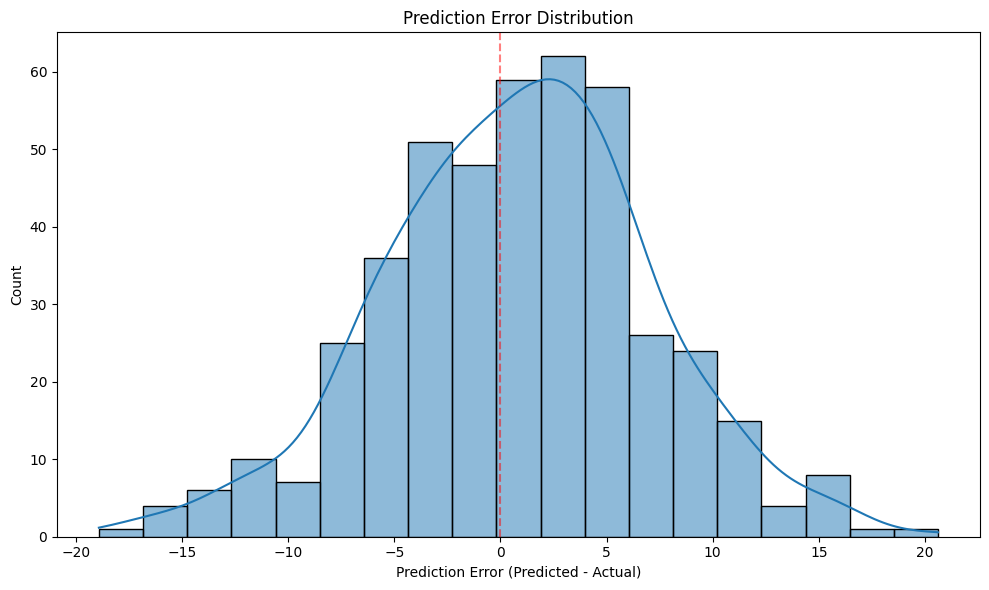


Total execution time: 5.19 seconds


In [14]:
# Import XGBoost
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import time

# Start timing
start_time = time.time()

# Define features (using the comprehensive set that performed well)
features = [
    'home', 'b2b', 'opp_b2b',
    'g_gsaa_rolling_avg', 'g_shots_against_rolling_avg', 'g_shots_against_rolling_std',
    'g_sv_pct_rolling_avg', 'g_sv_pct_rolling_std',
    'g_hdsv_pct_rolling_avg', 'g_mdsv_pct_rolling_avg',
    'g_games_last_7', 'g_days_rest',
    'ff%', 'cf%', 'sf%', 'xgf%', 'hdcf%', 'scf%'
]

# Prepare the data
X = processed_df[features].copy()
y = processed_df['res_saves']

# Handle missing values
X = X.fillna(X.mean())

# Define train/test split based on time
split_date = processed_df['game_date'].max() - pd.Timedelta(days=30)  # Use last 30 days as test set

# Create train/test sets based on date
train_mask = processed_df['game_date'] <= split_date
test_mask = processed_df['game_date'] > split_date

X_train = X[train_mask]
X_test = X[test_mask]
y_train = processed_df[train_mask]['res_saves']
y_test = processed_df[test_mask]['res_saves']

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define a more focused parameter grid to reduce computation time
param_grid = {
    'n_estimators': [100, 300],
    'max_depth': [3, 5],
    'learning_rate': [0.05, 0.1],
    'min_child_weight': [1, 3],
    'subsample': [0.8],
    'colsample_bytree': [0.8],
    'gamma': [0],
    'reg_alpha': [0],
    'reg_lambda': [1.0]
}

# Initialize the model without early stopping
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    n_jobs=-1
)

# Set up TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=3)  # Reduced from 5 to 3 for faster execution

# Calculate and print total number of combinations
n_combinations = np.prod([len(v) for v in param_grid.values()])
print(f"\nTotal number of parameter combinations: {n_combinations}")
print(f"Total number of fits: {n_combinations * 3}")  # 3 is the number of CV splits

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=tscv,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=2
)

print("\nStarting grid search...")
# Actually run the grid search
grid_search.fit(X_train_scaled, y_train)

# Print results
print("\nBest parameters found:")
print(grid_search.best_params_)

print("\nBest score:")
print(f"RMSE: {np.sqrt(-grid_search.best_score_):.4f}")

# Train final model with best parameters and early stopping
final_model = xgb.XGBRegressor(
    **grid_search.best_params_,
    random_state=42,
    early_stopping_rounds=20
)

# Fit final model with validation set for early stopping
final_model.fit(
    X_train_scaled, 
    y_train,
    eval_set=[(X_test_scaled, y_test)],
    verbose=False
)

# Make predictions
y_pred = final_model.predict(X_test_scaled)

# Calculate metrics
final_metrics = {
    'r2_score': r2_score(y_test, y_pred),
    'mae': mean_absolute_error(y_test, y_pred),
    'rmse': np.sqrt(mean_squared_error(y_test, y_pred))
}

print("\nFinal Model Metrics:")
print(f"R² Score: {final_metrics['r2_score']:.3f}")
print(f"MAE: {final_metrics['mae']:.3f}")
print(f"RMSE: {final_metrics['rmse']:.3f}")

# Plot feature importance
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': final_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(data=feature_importance, x='importance', y='feature')
plt.title('Feature Importance from Best Model')
plt.tight_layout()
plt.show()

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Perfect Prediction')
plt.xlabel('Actual Saves')
plt.ylabel('Predicted Saves')
plt.title('Final Model: Actual vs Predicted Saves')
plt.legend()
plt.tight_layout()
plt.show()

# Plot prediction errors
errors = y_pred - y_test
plt.figure(figsize=(10, 6))
sns.histplot(errors, kde=True)
plt.axvline(x=0, color='r', linestyle='--', alpha=0.5)
plt.title('Prediction Error Distribution')
plt.xlabel('Prediction Error (Predicted - Actual)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Calculate execution time
execution_time = time.time() - start_time
print(f"\nTotal execution time: {execution_time:.2f} seconds")

Training set size: 6582 samples
Test set size: 446 samples
Training voting ensemble model...

===== Model Evaluation Metrics =====

----- Regression Performance -----
R² Score: 0.1587
Explained Variance: 0.1686
Mean Absolute Error: 4.9343 saves
Median Absolute Error: 4.1605 saves
Root Mean Squared Error: 6.2334 saves
Maximum Error: 21.1815 saves

----- Error Distribution -----
Mean Error: 0.6757 saves
Error Standard Deviation: 6.1967
Error Skewness: -0.0891
Error Kurtosis: 0.2697
Normality Test p-value: 0.3495

----- Error Percentiles -----
Min Error: -18.7497 saves
25th Percentile: -3.2731 saves
Median Error: 0.8740 saves
75th Percentile: 4.5650 saves
Max Error: 21.1815 saves
Interquartile Range: 7.8381 saves

----- Prediction Accuracy -----
Predictions within ±1 saves: 12.33%
Predictions within ±2 saves: 22.87%
Predictions within ±3 saves: 37.22%
Predictions within ±5 saves: 61.43%


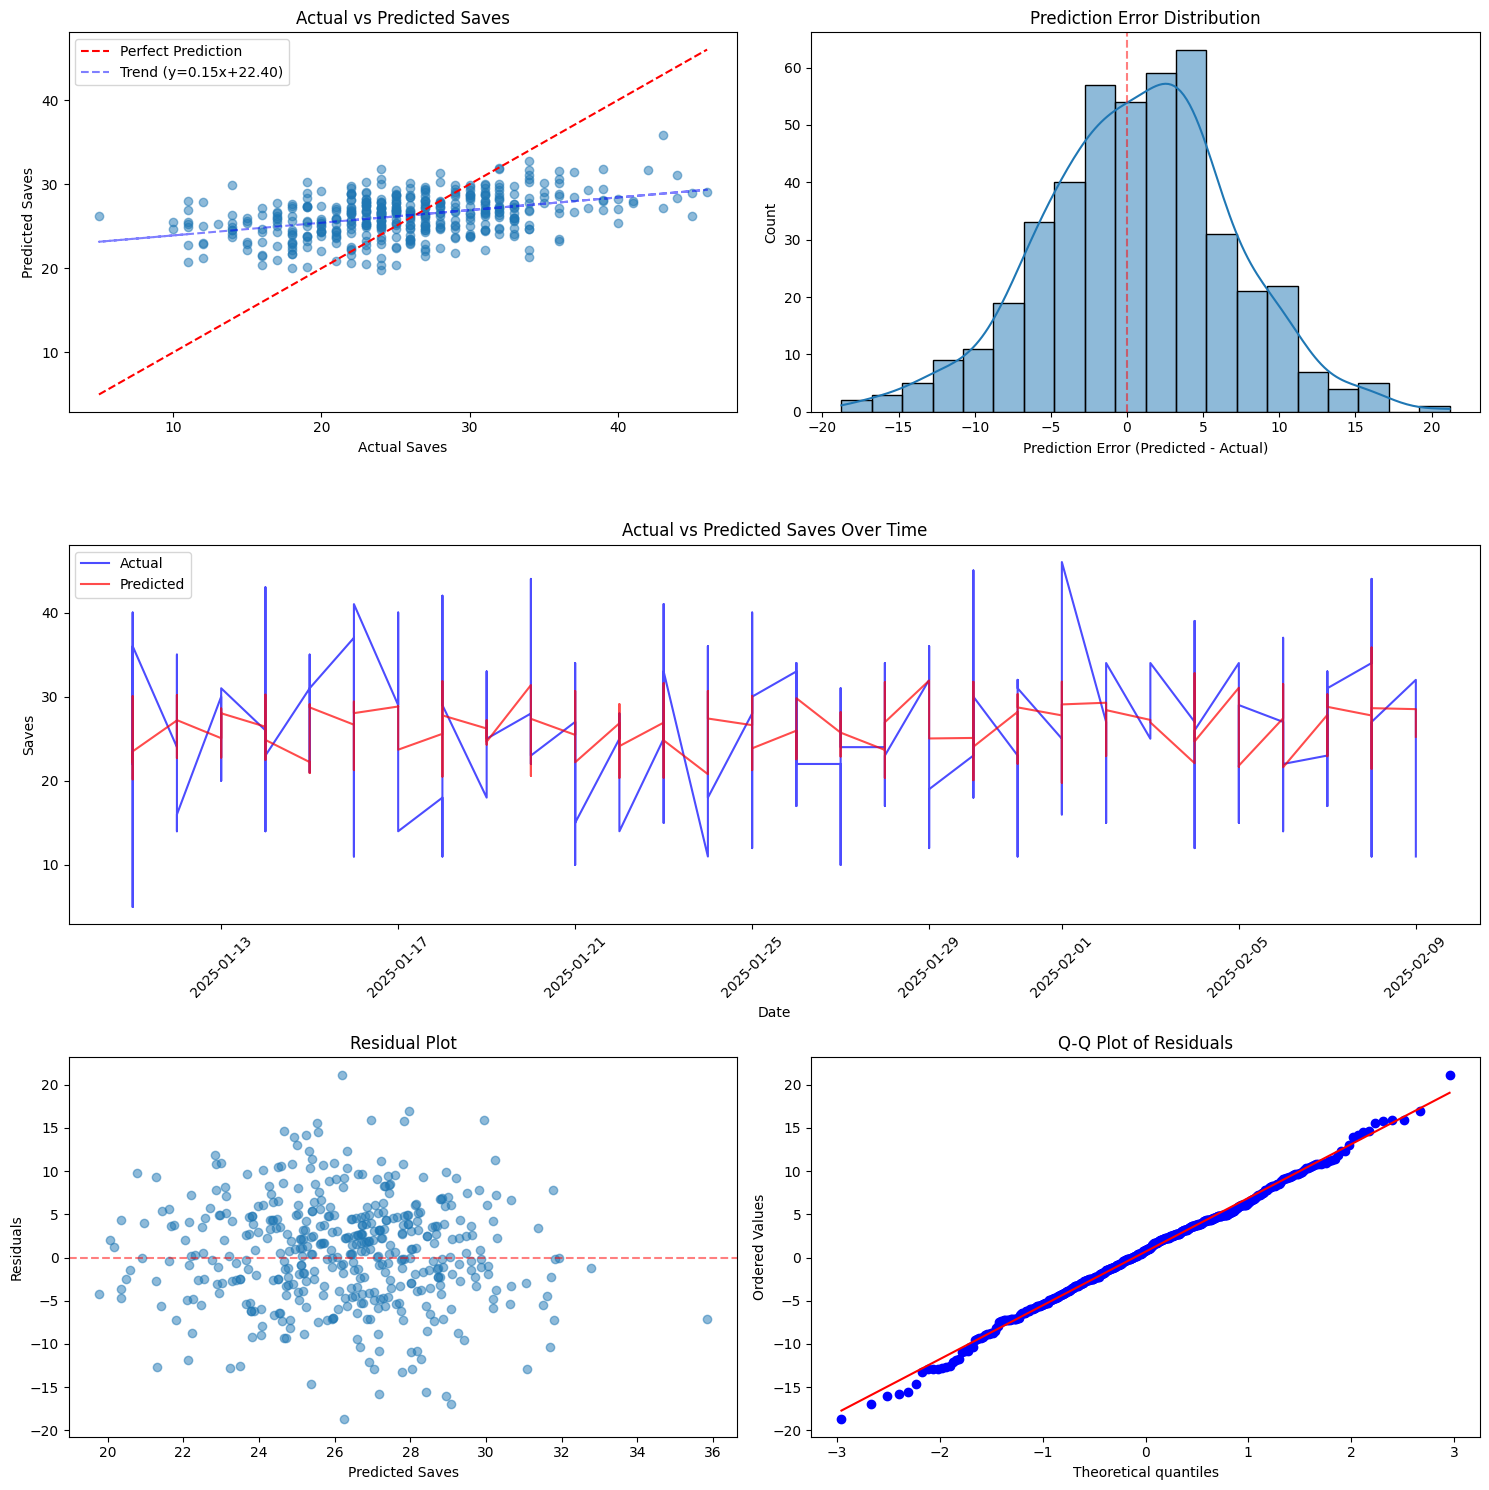

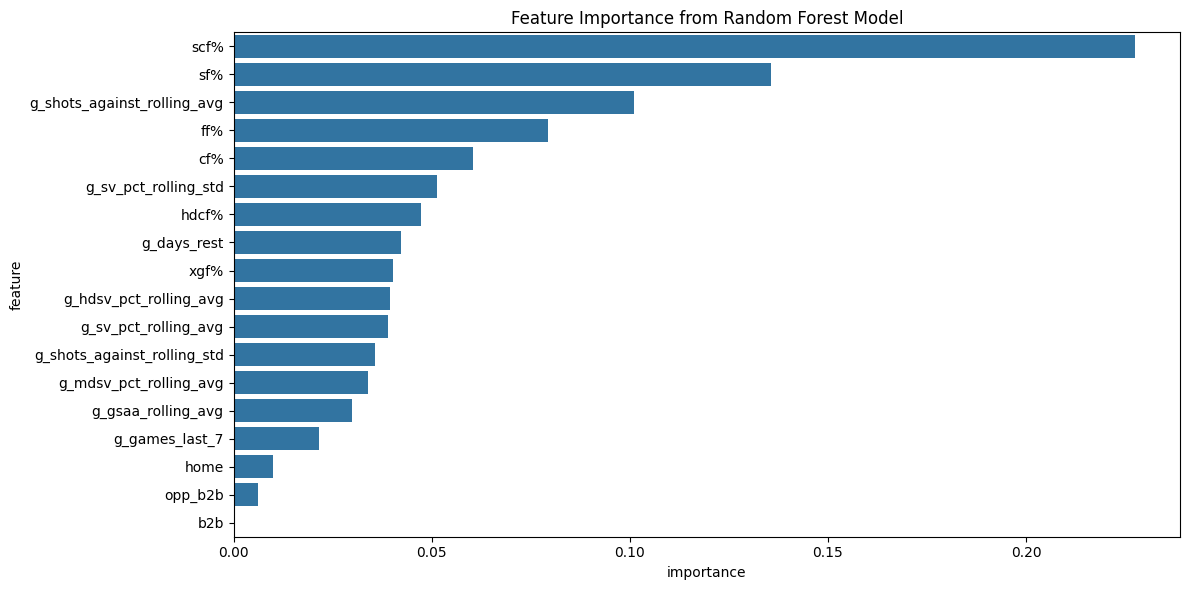


Total execution time: 10.61 seconds


In [15]:
from sklearn.ensemble import VotingRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, explained_variance_score, median_absolute_error, max_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from scipy import stats

# Start timing
start_time = time.time()

# Define features (using the comprehensive set that performed well)
features = [
    'home', 'b2b', 'opp_b2b',
    'g_gsaa_rolling_avg', 'g_shots_against_rolling_avg', 'g_shots_against_rolling_std',
    'g_sv_pct_rolling_avg', 'g_sv_pct_rolling_std',
    'g_hdsv_pct_rolling_avg', 'g_mdsv_pct_rolling_avg',
    'g_games_last_7', 'g_days_rest',
    'ff%', 'cf%', 'sf%', 'xgf%', 'hdcf%', 'scf%'
]

# Prepare the data
X = processed_df[features].copy()
y = processed_df['res_saves']

# Handle missing values
X = X.fillna(X.mean())

# Define train/test split based on time
split_date = processed_df['game_date'].max() - pd.Timedelta(days=30)  # Use last 30 days as test set

# Create train/test sets based on date
train_mask = processed_df['game_date'] <= split_date
test_mask = processed_df['game_date'] > split_date

X_train = X[train_mask]
X_test = X[test_mask]
y_train = processed_df[train_mask]['res_saves']
y_test = processed_df[test_mask]['res_saves']

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")

# Create base models
base_models = [
    ('rf', RandomForestRegressor(n_estimators=500, max_depth=10, bootstrap=True, max_features='sqrt', min_samples_leaf=4, min_samples_split=10, random_state=42)),
    ('gbr', GradientBoostingRegressor(n_estimators=200, max_depth=5, random_state=42)),
    ('ridge', Ridge(alpha=1.0, random_state=42)),
    ('lasso', Lasso(alpha=0.01, random_state=42)),
    ('elasticnet', ElasticNet(alpha=0.01, l1_ratio=0.5, random_state=42))
]

# Create voting ensemble (simpler than stacking)
voting_model = VotingRegressor(
    estimators=base_models,
    weights=[0.3, 0.3, 0.2, 0.1, 0.1]  # Giving more weight to tree-based models
)

# Create pipeline with scaling
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', voting_model)
])

# Train the model
print("Training voting ensemble model...")
pipeline.fit(X_train, y_train)

# Make predictions
y_pred = pipeline.predict(X_test)

# Calculate comprehensive metrics
metrics = {
    'r2_score': r2_score(y_test, y_pred),
    'explained_variance': explained_variance_score(y_test, y_pred),
    'mae': mean_absolute_error(y_test, y_pred),
    'median_ae': median_absolute_error(y_test, y_pred),
    'mse': mean_squared_error(y_test, y_pred),
    'rmse': np.sqrt(mean_squared_error(y_test, y_pred)),
    'max_error': max_error(y_test, y_pred),
    'mean_error': np.mean(y_pred - y_test),
    'std_error': np.std(y_pred - y_test)
}

# Calculate additional statistical metrics
errors = y_pred - y_test
metrics.update({
    'error_skewness': stats.skew(errors),
    'error_kurtosis': stats.kurtosis(errors),
    'error_normality_pvalue': stats.normaltest(errors)[1],
    'error_min': np.min(errors),
    'error_max': np.max(errors),
    'error_q1': np.percentile(errors, 25),
    'error_median': np.median(errors),
    'error_q3': np.percentile(errors, 75),
    'error_iqr': np.percentile(errors, 75) - np.percentile(errors, 25)
})

# Calculate percentage of predictions within different error margins
for margin in [1, 2, 3, 5]:
    metrics[f'within_{margin}_saves'] = np.mean(np.abs(errors) <= margin) * 100

# Print metrics in a formatted table
print("\n===== Model Evaluation Metrics =====")
print("\n----- Regression Performance -----")
print(f"R² Score: {metrics['r2_score']:.4f}")
print(f"Explained Variance: {metrics['explained_variance']:.4f}")
print(f"Mean Absolute Error: {metrics['mae']:.4f} saves")
print(f"Median Absolute Error: {metrics['median_ae']:.4f} saves")
print(f"Root Mean Squared Error: {metrics['rmse']:.4f} saves")
print(f"Maximum Error: {metrics['max_error']:.4f} saves")

print("\n----- Error Distribution -----")
print(f"Mean Error: {metrics['mean_error']:.4f} saves")
print(f"Error Standard Deviation: {metrics['std_error']:.4f}")
print(f"Error Skewness: {metrics['error_skewness']:.4f}")
print(f"Error Kurtosis: {metrics['error_kurtosis']:.4f}")
print(f"Normality Test p-value: {metrics['error_normality_pvalue']:.4f}")

print("\n----- Error Percentiles -----")
print(f"Min Error: {metrics['error_min']:.4f} saves")
print(f"25th Percentile: {metrics['error_q1']:.4f} saves")
print(f"Median Error: {metrics['error_median']:.4f} saves")
print(f"75th Percentile: {metrics['error_q3']:.4f} saves")
print(f"Max Error: {metrics['error_max']:.4f} saves")
print(f"Interquartile Range: {metrics['error_iqr']:.4f} saves")

print("\n----- Prediction Accuracy -----")
for margin in [1, 2, 3, 5]:
    print(f"Predictions within ±{margin} saves: {metrics[f'within_{margin}_saves']:.2f}%")

# Create a figure with multiple subplots for visualization
fig = plt.figure(figsize=(15, 15))
gs = fig.add_gridspec(3, 2)

# 1. Actual vs Predicted scatter plot
ax1 = fig.add_subplot(gs[0, 0])
ax1.scatter(y_test, y_pred, alpha=0.5)
ax1.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Perfect Prediction')
z = np.polyfit(y_test, y_pred, 1)
p = np.poly1d(z)
ax1.plot(y_test, p(y_test), "b--", alpha=0.5, label=f'Trend (y={z[0]:.2f}x+{z[1]:.2f})')
ax1.set_xlabel('Actual Saves')
ax1.set_ylabel('Predicted Saves')
ax1.set_title('Actual vs Predicted Saves')
ax1.legend()

# 2. Error distribution histogram
ax2 = fig.add_subplot(gs[0, 1])
sns.histplot(errors, kde=True, ax=ax2)
ax2.axvline(x=0, color='r', linestyle='--', alpha=0.5)
ax2.set_title('Prediction Error Distribution')
ax2.set_xlabel('Prediction Error (Predicted - Actual)')
ax2.set_ylabel('Count')

# 3. Time series of actual vs predicted
ax3 = fig.add_subplot(gs[1, :])
# Get dates for test set
test_dates = processed_df.loc[test_mask, 'game_date']
ax3.plot(test_dates, y_test, 'b-', label='Actual', alpha=0.7)
ax3.plot(test_dates, y_pred, 'r-', label='Predicted', alpha=0.7)
ax3.set_title('Actual vs Predicted Saves Over Time')
ax3.set_xlabel('Date')
ax3.set_ylabel('Saves')
ax3.legend()
plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45)

# 4. Residual plot
ax4 = fig.add_subplot(gs[2, 0])
ax4.scatter(y_pred, errors, alpha=0.5)
ax4.axhline(y=0, color='r', linestyle='--', alpha=0.5)
ax4.set_xlabel('Predicted Saves')
ax4.set_ylabel('Residuals')
ax4.set_title('Residual Plot')

# 5. QQ plot for normality check
ax5 = fig.add_subplot(gs[2, 1])
stats.probplot(errors, plot=ax5)
ax5.set_title('Q-Q Plot of Residuals')

plt.tight_layout()
plt.show()

# Feature importance from Random Forest model
rf_model = pipeline.named_steps['model'].estimators_[0][1]
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(data=feature_importance, x='importance', y='feature')
plt.title('Feature Importance from Random Forest Model')
plt.tight_layout()
plt.show()

# Calculate execution time
execution_time = time.time() - start_time
print(f"\nTotal execution time: {execution_time:.2f} seconds")

Training set size: 6582 samples
Test set size: 446 samples
Using 24 features after engineering
Selected features:
  1. home
  2. g_gsaa_rolling_avg
  3. g_sv_pct_rolling_avg
  4. g_sv_pct_rolling_std
  5. ff%
  6. cf%
  7. sf%
  8. xgf%
  9. hdcf%
  10. scf%
  11. rest_b2b_interaction
  12. sv_pct_shots_interaction
  13. gsaa_squared
  14. sv_pct_squared
  15. hd_md_sv_ratio
Training neural network for 200 epochs...
Progress: [==] 2/200 epochs - 1.4s elapsed, ~133.9s remaining
Train loss: 370.9144, Val loss: 146.1135
Progress: [==] 4/200 epochs - 1.6s elapsed, ~79.4s remaining
Train loss: 126.4178, Val loss: 71.8603
Progress: [==] 6/200 epochs - 1.9s elapsed, ~61.4s remaining
Train loss: 88.4474, Val loss: 48.7462
Progress: [==] 8/200 epochs - 2.2s elapsed, ~53.4s remaining
Train loss: 74.9716, Val loss: 42.6044
Progress: [==] 10/200 epochs - 2.5s elapsed, ~47.8s remaining
Train loss: 71.5615, Val loss: 41.0182
Progress: [==] 12/200 epochs - 2.8s elapsed, ~43.7s remaining
Train loss: 6

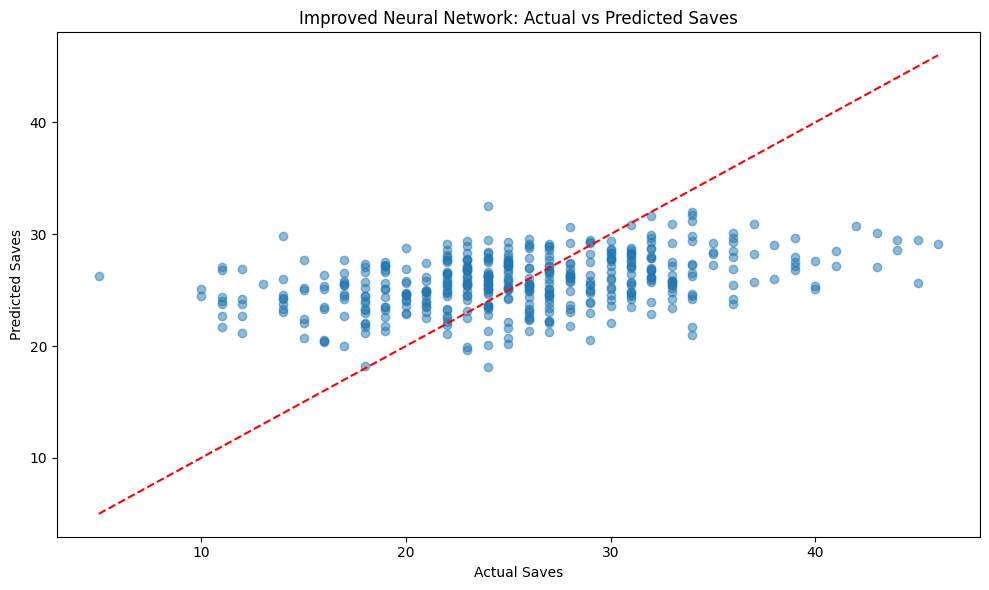

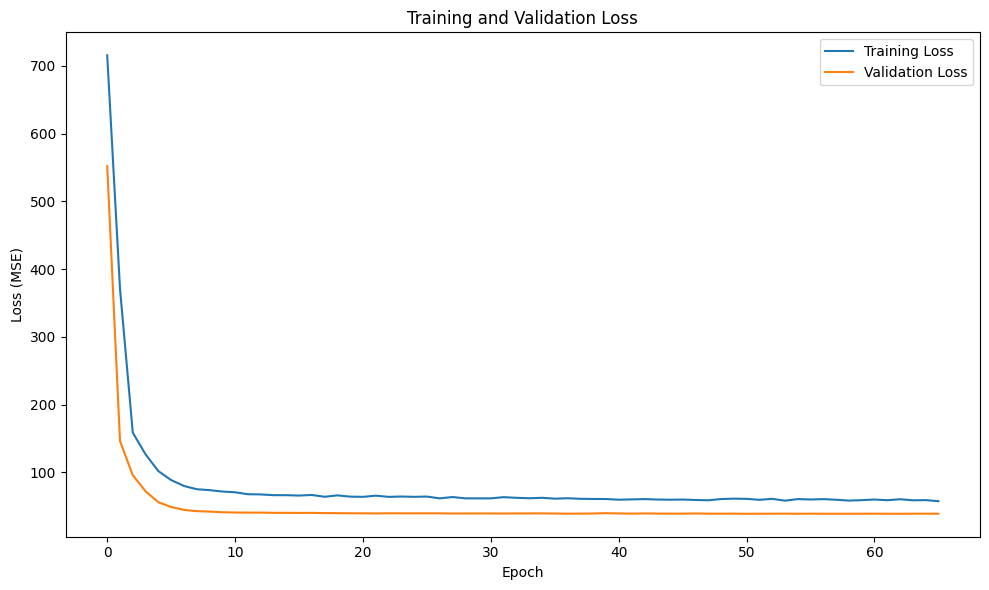


===== Improved Neural Network Model Evaluation =====
R² Score: 0.1598
Mean Absolute Error: 4.9517 saves
Root Mean Squared Error: 6.2295 saves
Predictions within ±1 saves: 11.21%
Predictions within ±2 saves: 21.30%
Predictions within ±3 saves: 37.00%
Predictions within ±5 saves: 61.21%


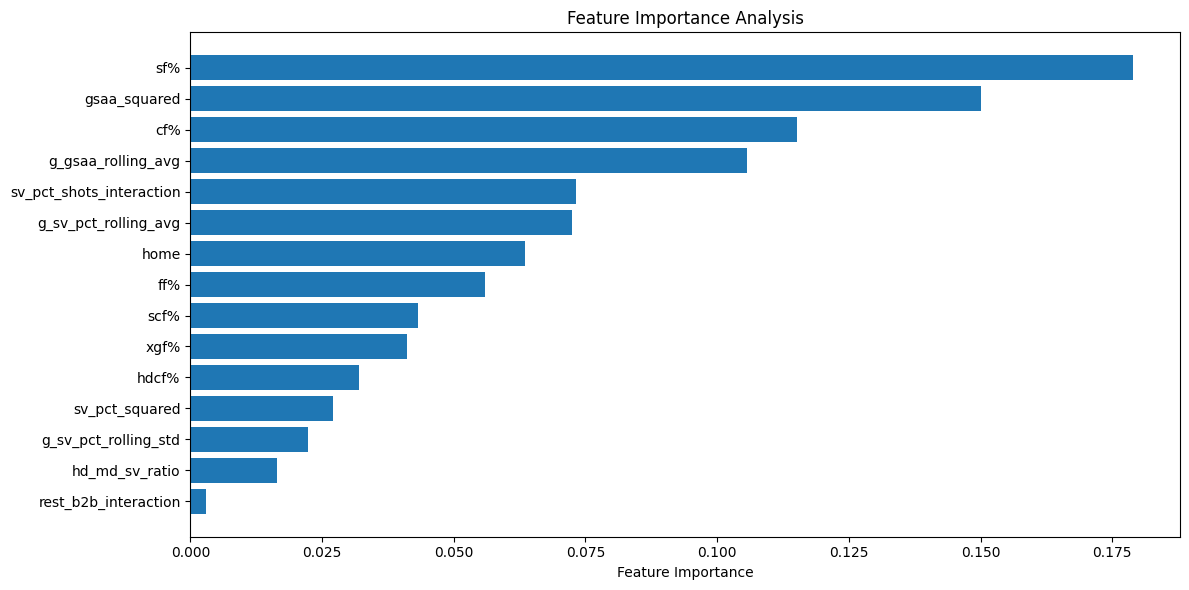

In [17]:


# Define a dataset class for our goalie data
class GoalieDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32).reshape(-1, 1)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Define a more complex neural network architecture
class GoalieNN(nn.Module):
    def __init__(self, input_size):
        super(GoalieNN, self).__init__()
        # More complex architecture with additional layers
        self.model = nn.Sequential(
            nn.Linear(input_size, 32),  # Larger first hidden layer
            nn.ReLU(),
            nn.Dropout(0.2),  # Add dropout for regularization
            nn.Linear(32, 16),  # Add another hidden layer
            nn.ReLU(),
            nn.Dropout(0.1),  # Add dropout for regularization
            nn.Linear(16, 1)
        )
    
    def forward(self, x):
        return self.model(x)

# Function to train the model with improved parameters
def train_nn_model_ultrafast(X_train, y_train, X_test, y_test, 
                             batch_size=64, epochs=200, learning_rate=0.001,
                             weight_decay=1e-5, patience=10):
    """
    Ultra-fast training function with improved parameters
    """
    # Start timing
    start_time = time.time()
    
    # Create datasets and dataloaders
    train_dataset = GoalieDataset(X_train, y_train)
    test_dataset = GoalieDataset(X_test, y_test)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    # Initialize model, loss function, and optimizer
    model = GoalieNN(X_train.shape[1])
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    
    # Add learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)
    
    # Training loop
    train_losses = []
    val_losses = []
    best_model_state = None
    best_val_loss = float('inf')
    early_stopping_counter = 0
    
    print(f"Training neural network for {epochs} epochs...")
    print(f"Progress: [", end="")
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        
        # Quick validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in test_loader:
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()
        
        val_loss /= len(test_loader)
        val_losses.append(val_loss)
        
        # Update learning rate based on validation loss
        scheduler.step(val_loss)
        
        # Early stopping logic
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict().copy()
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
            
        if early_stopping_counter >= patience:
            print(f"\nEarly stopping triggered after {epoch+1} epochs")
            break
        
        # Print progress
        print("=", end="", flush=True)
        
        # Print detailed info every few epochs
        if (epoch + 1) % 2 == 0 or epoch == epochs - 1:
            elapsed = time.time() - start_time
            eta = elapsed / (epoch + 1) * (epochs - epoch - 1)
            print(f"] {epoch+1}/{epochs} epochs - {elapsed:.1f}s elapsed, ~{eta:.1f}s remaining")
            print(f"Train loss: {train_loss:.4f}, Val loss: {val_loss:.4f}")
            if epoch < epochs - 1:
                print(f"Progress: [", end="")
    
    # Load best model
    model.load_state_dict(best_model_state)
    
    # Evaluate on test set
    model.eval()
    with torch.no_grad():
        y_pred = model(torch.tensor(X_test, dtype=torch.float32)).numpy().flatten()
    
    # Calculate metrics
    metrics = {
        'r2_score': r2_score(y_test, y_pred),
        'mae': mean_absolute_error(y_test, y_pred),
        'rmse': np.sqrt(mean_squared_error(y_test, y_pred)),
        'train_losses': train_losses,
        'val_losses': val_losses
    }
    
    # Calculate execution time
    execution_time = time.time() - start_time
    print(f"\nTraining completed in {execution_time:.2f} seconds")
    
    return model, y_pred, metrics

# Function to run an improved neural network evaluation
def run_improved_goalie_nn():
    """
    Run an improved version of the neural network model with feature engineering
    """
    # Define base features
    base_features = [
        'home', 'b2b', 'opp_b2b',
        'g_gsaa_rolling_avg', 'g_shots_against_rolling_avg', 'g_shots_against_rolling_std',
        'g_sv_pct_rolling_avg', 'g_sv_pct_rolling_std',
        'g_hdsv_pct_rolling_avg', 'g_mdsv_pct_rolling_avg',
        'g_games_last_7', 'g_days_rest',
        'ff%', 'cf%', 'sf%', 'xgf%', 'hdcf%', 'scf%'
    ]

    # Prepare the data
    X = processed_df[base_features].copy()
    y = processed_df['res_saves']
    
    # Feature engineering - create interaction terms
    X['rest_b2b_interaction'] = X['g_days_rest'] * X['b2b']
    X['sv_pct_shots_interaction'] = X['g_sv_pct_rolling_avg'] * X['g_shots_against_rolling_avg']
    X['home_sv_pct_interaction'] = X['home'] * X['g_sv_pct_rolling_avg']
    
    # Create polynomial features for key metrics
    X['gsaa_squared'] = X['g_gsaa_rolling_avg'] ** 2
    X['sv_pct_squared'] = X['g_sv_pct_rolling_avg'] ** 2
    
    # Create ratio features
    X['hd_md_sv_ratio'] = X['g_hdsv_pct_rolling_avg'] / X['g_mdsv_pct_rolling_avg'].replace(0, 0.001)
    
    # Handle missing values
    X = X.fillna(X.mean())

    # Define train/test split based on time
    split_date = processed_df['game_date'].max() - pd.Timedelta(days=30)

    # Create train/test sets based on date
    train_mask = processed_df['game_date'] <= split_date
    test_mask = processed_df['game_date'] > split_date

    X_train = X[train_mask]
    X_test = X[test_mask]
    y_train = processed_df[train_mask]['res_saves']
    y_test = processed_df[test_mask]['res_saves']

    print(f"Training set size: {X_train.shape[0]} samples")
    print(f"Test set size: {X_test.shape[0]} samples")
    print(f"Using {X_train.shape[1]} features after engineering")
    
    # Feature selection using mutual information
    from sklearn.feature_selection import SelectKBest, mutual_info_regression
    
    # Select top features (adjust k as needed)
    k = min(15, X_train.shape[1])
    selector = SelectKBest(mutual_info_regression, k=k)
    X_train_selected = selector.fit_transform(X_train, y_train)
    X_test_selected = selector.transform(X_test)
    
    # Get names of selected features
    selected_indices = selector.get_support(indices=True)
    selected_features = X_train.columns[selected_indices].tolist()
    
    print("Selected features:")
    for i, feature in enumerate(selected_features):
        print(f"  {i+1}. {feature}")

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_selected)
    X_test_scaled = scaler.transform(X_test_selected)

    # Train the neural network with improved settings
    model, y_pred, metrics = train_nn_model_ultrafast(
        X_train_scaled, y_train, X_test_scaled, y_test,
        batch_size=64,
        epochs=200,
        learning_rate=0.001,
        weight_decay=1e-5,
        patience=15
    )
    
    # Plot predictions
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Actual Saves')
    plt.ylabel('Predicted Saves')
    plt.title('Improved Neural Network: Actual vs Predicted Saves')
    plt.tight_layout()
    plt.show()
    
    # Plot training and validation loss
    plt.figure(figsize=(10, 6))
    plt.plot(metrics['train_losses'], label='Training Loss')
    plt.plot(metrics['val_losses'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Print metrics
    print("\n===== Improved Neural Network Model Evaluation =====")
    print(f"R² Score: {metrics['r2_score']:.4f}")
    print(f"Mean Absolute Error: {metrics['mae']:.4f} saves")
    print(f"Root Mean Squared Error: {metrics['rmse']:.4f} saves")
    
    # Calculate percentage of predictions within different error margins
    errors = y_pred - y_test
    for margin in [1, 2, 3, 5]:
        within_margin = np.mean(np.abs(errors) <= margin) * 100
        print(f"Predictions within ±{margin} saves: {within_margin:.2f}%")
    
    # Feature importance analysis
    if hasattr(model, 'feature_importances_'):
        # For tree-based models
        feature_importance = model.feature_importances_
    else:
        # For neural networks, use a simple sensitivity analysis
        feature_importance = []
        model.eval()
        with torch.no_grad():
            baseline = model(torch.tensor(X_test_scaled, dtype=torch.float32)).numpy().flatten()
            for i in range(X_test_scaled.shape[1]):
                # Perturb each feature and measure the effect
                X_perturbed = X_test_scaled.copy()
                X_perturbed[:, i] += 0.1 * X_perturbed[:, i].std()
                perturbed = model(torch.tensor(X_perturbed, dtype=torch.float32)).numpy().flatten()
                importance = np.mean(np.abs(perturbed - baseline))
                feature_importance.append(importance)
        
        # Normalize importances
        feature_importance = np.array(feature_importance) / sum(feature_importance)
    
    # Plot feature importance
    plt.figure(figsize=(12, 6))
    sorted_idx = np.argsort(feature_importance)
    plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx])
    plt.yticks(range(len(sorted_idx)), [selected_features[i] for i in sorted_idx])
    plt.xlabel('Feature Importance')
    plt.title('Feature Importance Analysis')
    plt.tight_layout()
    plt.show()
    
    return model, scaler, metrics, selected_features

# Run the improved neural network model
improved_nn_model, improved_nn_scaler, improved_nn_metrics, selected_features = run_improved_goalie_nn()